<a href="https://colab.research.google.com/github/iamatul1214/Pytorch/blob/main/TransferLearning_using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
root = "/content/drive/MyDrive/CNN using Pytorch"
os.chdir(root)

In [2]:
!pwd

/content/drive/MyDrive/CNN using Pytorch


In [53]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm import tqdm

import urllib.request as request

In [58]:
class Config:
  def __init__(self):
    self.ROOT_DATA_DIR = "hymenoptera_data"
    self.EPOCH = 75
    self.BATCH_SIZE = 32
    self.LEARNING_RATE = 0.01
    self.IMAGE_SIZE = (224, 224)
    self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"this notebook is using device: {self.DEVICE}")
    self.SEED = 2022

  def create_dir(self, dir_path):
    os.makedirs(dir_path, exist_ok=True)
    print(f"{dir_path} directory is created")

config = Config()

this notebook is using device: cpu


## Downloading the datset

In [5]:
data_URL = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

In [6]:
config.create_dir(config.ROOT_DATA_DIR)

hymenoptera_data directory is created


In [7]:
data_zip_file = "data.zip"

data_file_path = os.path.join(config.ROOT_DATA_DIR, data_zip_file)

request.urlretrieve(data_URL, data_file_path)


('hymenoptera_data/data.zip', <http.client.HTTPMessage at 0x7f7d133ae850>)

In [8]:
## Unzipping the data.zip
from zipfile import ZipFile

def unzip_file(source:str, dest:str) -> None:
  print("extraction started...")
  with ZipFile(source,'r') as zip_f:
    zip_f.extractall(dest)
  print(f"extraction completed from {source} to {dest}")


In [9]:
unzip_file(data_file_path, config.ROOT_DATA_DIR)

extraction started...
extraction completed from hymenoptera_data/data.zip to hymenoptera_data


### The dataset has been extracted and is automatically seperated for training and testing datasets. Now we need to create data loader. But before that as we know, we use os library to create directory paths, but when we have longer paths we will require to pass the list. So to avoid this we use pathlib library.

In [10]:
from pathlib import Path

In [11]:
Path("hymenoptera_data/hymenoptera_data/train")   ## This library will create path() in any OS

PosixPath('hymenoptera_data/hymenoptera_data/train')

In [12]:
train_path = Path("hymenoptera_data/hymenoptera_data/train")
test_path = Path("hymenoptera_data/hymenoptera_data/val")

### Another best practice is to normalize the images as well, the way we used to normalize structured data. For this we do following

#### We normalize the each channel present on the image, for eg if channel as 1 channel (i.e it is gray image) then we calculate its mean, and standard deviation.
#### If an image has 3 channels then we perform this three times

mean of the each channel of the image

for 28, 28 img size
mean = sum(value of the pixels)/784 

std = (data - mean) / std

In [13]:
## Lets assume the mean and standard deviation for our images which are in RGB are as follows
mean = torch.tensor([0.5,0.5,0.5])
std = torch.tensor([0.5,0.5,0.5])

In [14]:
## Let's do some transformation of our images, which include resizing the image, rotating the image, normalize the image and etc.

train_transforms = transforms.Compose([
                                       transforms.Resize(config.IMAGE_SIZE),
                                       transforms.RandomRotation(degrees=20),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
                                       transforms.Resize(config.IMAGE_SIZE),
                                       transforms.ToTensor(),   
                                       transforms.Normalize(mean, std)
])

## We don't want to rotate our testing images, we just want testing images to be classified without rotation so that our model can perform better

In [15]:
## Now let's load the training and testing images from the folders, unlike in previous fashionmnist and mnist dataset, which were inbuilt.

train_data = datasets.ImageFolder(root = train_path, transform=train_transforms)
test_data = datasets.ImageFolder(root = test_path, transform=test_transforms)

## Please note that, datasets is the class of pytorch which has Imagefolder named method, which takes root of image folder and transform as paramter.

In [16]:
## Let's see what train_data stores
train_data

Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data/hymenoptera_data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
           )

In [17]:
test_data

Dataset ImageFolder
    Number of datapoints: 153
    Root location: hymenoptera_data/hymenoptera_data/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
           )

In [18]:
train_data.class_to_idx  
 ## pytorch automatically uses class_t-_idx dictionary to create the labels for the classes we need to classify. 
 ## Here it automatically took bees folder on 1 and ants folder on 0.

{'ants': 0, 'bees': 1}

In [19]:
## Let's create the label map
label_map = train_data.class_to_idx  
label_map

{'ants': 0, 'bees': 1}

In [20]:
## Let's load the data into batches
train_loader = DataLoader(train_data, shuffle = True, batch_size=config.BATCH_SIZE)
test_loader = DataLoader(test_data, shuffle = False, batch_size=config.BATCH_SIZE)

In [21]:
data = next(iter(train_loader))
data

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
         

In [22]:
len(data)    ## Even it has two things one is image and other labels

2

In [23]:
images, label = data
images.shape   ## It is colored image

torch.Size([32, 3, 224, 224])

In [24]:
label.shape

torch.Size([32])

In [25]:
img = images[11]
img.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


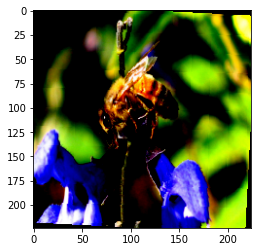

In [26]:
plt.imshow(img.permute(1,2,0))

In [27]:
permute_size = img.permute(1,2,0)   ## squeeze doesn't work with rgb channeled images hence we use permute()
print(permute_size.shape)

# permute is used to replace the indexing of the numbers present. we can see that in output
permute_size = img.permute(1,0,2)
print(permute_size.shape)

torch.Size([224, 224, 3])
torch.Size([224, 3, 224])


## Download a pre trained model 

In [28]:
model = models.alexnet(pretrained=True)   ## alexnet is an architecture which came in 2014, it is trained on 1000 classes

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [29]:
## Let's see the alexnet model arch
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Let's count the number of trainable parameters in alexnet

In [30]:
def count_params(model):
  model_params= {"Modules":list(), "Parameters":list()}
  total={"trainable":0, "non-trainable":0}

  for name, parameters in model.named_parameters():
    param = parameters.numel()

    if not parameters.requires_grad:
      total['non-trainable'] += param
      continue
    model_params["Modules"].append(name)
    model_params["Parameters"].append(param)
    total["trainable"] += param

  df=pd.DataFrame(model_params)
  df=df.style.set_caption(f" total parameters of the model : {total}")
  return df

count_params(model)

,Modules,Parameters
0,features.0.weight,23232
1,features.0.bias,64
2,features.3.weight,307200
3,features.3.bias,192
4,features.6.weight,663552
5,features.6.bias,384
6,features.8.weight,884736
7,features.8.bias,256
8,features.10.weight,589824
9,features.10.bias,256


### So as we saw in above output the no of trainable paramteres are lot, and it will take a lot of time if we start training it from scratch. So that's why we will freeze some layers and just train the last layers.

In [31]:
## Let's freeze all the parameters and layers

for parameters in model.parameters():
  parameters.requires_grad = False

In [33]:
count_params(model)    ## Now all the paramters are non trainable

,Modules,Parameters


In [37]:
from torch.nn.modules.dropout import Dropout
## We will create changes in the classifier layers which is responsible for classifying.

model.classifier = nn.Sequential(
    nn.Linear(in_features=9216, out_features=100, bias=True),  ## we changed out_features to be 100
    nn.ReLU(inplace = True),
    nn.Dropout(p=0.5, inplace=False),                      ## During training, randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution. Each channel will be zeroed out independently on every forward call.
    nn.Linear(in_features = 100, out_features=2, bias=True)   ## We will finally have 2 features out because we hve only two classification to make
)


In [36]:
model.classifier

Sequential(
  (0): Linear(in_features=9216, out_features=100, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=100, out_features=2, bias=True)
)

In [39]:
## Now let's count the parameters
count_params(model)

,Modules,Parameters
0,classifier.0.weight,921600
1,classifier.0.bias,100
2,classifier.3.weight,200
3,classifier.3.bias,2


In [40]:
criterion = nn.CrossEntropyLoss()   ## defining our loss function
optimizer = torch.optim.Adam(model.parameters(), lr = config.LEARNING_RATE)

In [60]:
train_loss = []
for epoch in range(config.EPOCH):
  with tqdm(train_loader) as tqdm_epoch:
    for images, label in tqdm_epoch:
      tqdm_epoch.set_description(f"EPOCH {epoch + 1}/{config.EPOCH}")

      images = images.to(config.DEVICE)
      label = label.to(config.DEVICE)

      ## forward pass

      output =  model(images)
      loss = criterion(output, label)


      ## backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step

      train_loss.append(loss.item())
      tqdm_epoch.set_postfix(loss = loss.item())

EPOCH 75/75: 100%|██████████| 8/8 [00:09<00:00,  1.16s/it, loss=0.843]


## Evaluating the model


In [61]:
pred = np.array([])
target = np.array([])

with torch.no_grad():    ## because we are only doing forward pass to predict and not backward pass, hence no need of gradient calculation
  for batch, data in enumerate(train_loader): # Since, enumerator returns the index and data. Hence, here index is the batch and data contains labels and images
    images = data[0].to(config.DEVICE)     # converting the images for GPU
    labels = data[1].to(config.DEVICE)

    y_pred = model(images)

    pred = np.concatenate((pred, torch.argmax(y_pred,1).cpu().numpy()))   ## we selected the probability of the highest class prediction using argmax, converted it into cpu as pred is a numpy array and then converted it into numpy()
    target = np.concatenate((target, labels.cpu().numpy()))

In [62]:
## Let's print the confusion matrix
cm = confusion_matrix(target, pred)
cm

array([[32, 91],
       [49, 72]])

In [63]:
label_map

{'ants': 0, 'bees': 1}

In [64]:
## Let's reverse the label maps
converted_label_map = {value:key for key, value in label_map.items()}
converted_label_map

{0: 'ants', 1: 'bees'}

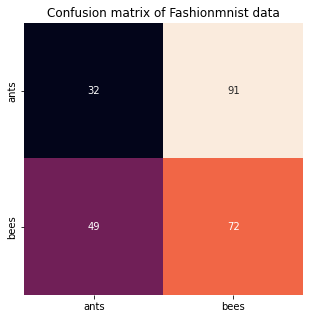

In [65]:
## Let's plot the confusion matrix
plt.figure(figsize=(5,5))
plt.title("Confusion matrix of Fashionmnist data")
sns.heatmap(cm, annot = True,fmt='d', xticklabels=converted_label_map.values(), yticklabels=converted_label_map.values(), cbar = False)

In [66]:
score =  accuracy_score(target, pred)
score

0.4262295081967213

## predict on our model

In [67]:
data = next(iter(test_loader))    #As equvilent to writing--->  i[0] for i in test_data_loader
data     

[tensor([[[[ 0.6078,  0.5765,  0.7176,  ...,  0.4275,  0.3490,  0.2784],
           [ 0.4667,  0.5373,  0.6078,  ...,  0.4353,  0.4353,  0.3176],
           [ 0.5294,  0.5529,  0.4902,  ...,  0.3569,  0.3569,  0.3569],
           ...,
           [ 0.0980,  0.3490,  0.6941,  ...,  0.2392,  0.2863,  0.6078],
           [ 0.2863,  0.4588,  0.6157,  ...,  0.0667,  0.1059,  0.1922],
           [ 0.2706,  0.3961,  0.5294,  ...,  0.0275,  0.2549,  0.0902]],
 
          [[ 0.9216,  0.8275,  0.8980,  ...,  0.7412,  0.5686,  0.4667],
           [ 0.8353,  0.8745,  0.8980,  ...,  0.7490,  0.6314,  0.4902],
           [ 0.8196,  0.8588,  0.7961,  ...,  0.6706,  0.6157,  0.6157],
           ...,
           [ 0.3255,  0.4510,  0.8588,  ...,  0.3569,  0.4196,  0.7255],
           [ 0.5686,  0.6000,  0.8118,  ...,  0.1843,  0.2392,  0.2549],
           [ 0.5059,  0.6314,  0.7961,  ...,  0.1294,  0.4196,  0.1529]],
 
          [[ 0.9843,  0.8902,  0.9216,  ...,  0.7961,  0.6549,  0.4275],
           [ 

In [68]:
## Let;s display any of the random image 
img = images[3]
img

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


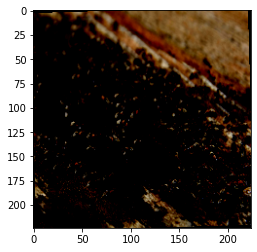

In [69]:
print(img.permute(1,2,0).shape)
plt.imshow(img.permute(1,2,0))

In [75]:
def predict(data, model,device,label_map,index=0):
  images, labels = data
  img = images[index]
  label = labels[index]

  plt.imshow(img.permute(1,2,0))
  logit = model(img.unsqueeze(0).to(device))
  pred_prob = F.softmax(logit, dim=1)
  max_prob = torch.argmax(pred_prob).item()

  predicted_label = label_map[max_prob]
  actual_label = label_map[label.item()]


  plt.title(f"Actual label = {actual_label} | Predicted label = {predicted_label}")
  plt.axis("off")
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


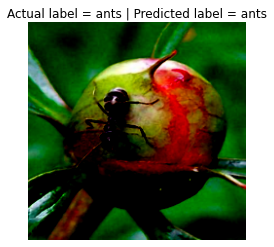

In [76]:
predict(data, model, config.DEVICE,converted_label_map, index=12)